<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/VIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import datetime

In [2]:
data = pd.read_csv('/content/vix.csv')

In [3]:
data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [4]:
del data['time']


In [5]:
data= data.set_index('date')


In [6]:
data=data['01-01-2015':]

In [9]:
data_subset = data[['close','INDIAVIX, NSE: Close']]

In [10]:
data_subset.tail(2)


,close,"INDIAVIX, NSE: Close"
date,,
19-07-2022,16346.95,17.202499
20-07-2022,16519.60,16.822500


In [15]:
data['sig_inter'] = abs((data['INDIAVIX, NSE: Close'].rolling(window=50).mean()-data['INDIAVIX, NSE: Close'])/data['INDIAVIX, NSE: Close'].rolling(window=50).mean())*100

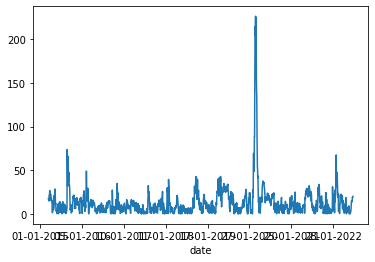

In [21]:
data['sig_inter'].plot()

In [26]:
data['sig']=np.where(data['sig_inter']>35,1,0)

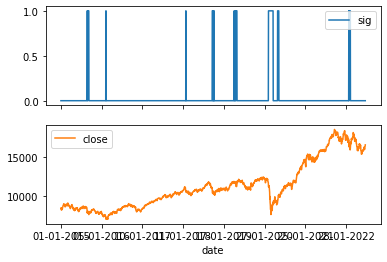

In [27]:
data[['sig','close']].plot(subplots=True);